# Prepare and analyse data for model training and evaluation

# Prepare programming environment

## Load necessary packages

In [1]:
# Import packages
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

## Get required data

In [2]:
# Load data obtained from multi-pass simulation
# Attention memory intensive!
with open(r"../data/interim/results_simulation_42.pickle", "rb") as output_file:
        data_1 = pickle.load(output_file)
with open(r"../data/interim/results_simulation_66.pickle", "rb") as output_file:
        data_2 = pickle.load(output_file)
with open(r"../data/interim/results_simulation_108.pickle", "rb") as output_file:
        data_3 = pickle.load(output_file)
with open(r"../data/interim/results_simulation_97.pickle", "rb") as output_file:
        data_4 = pickle.load(output_file)
# We are using the last simulation batch as test data for the different approaches
with open(r"../data/interim/results_simulation_07.pickle", "rb") as output_file:
        data_5 = pickle.load(output_file)

## Define global constants

In [3]:
RANDOM_STATE = 42

# Understand data

The generation of the data took 654,121.12 seconds or approximately eight day respectively.

In [4]:
# Combine data sources
data = pd.concat([data_1, data_2, data_3, data_4]).reset_index(drop = True)
print("The resulting dataframes shape:", data.shape)

The resulting dataframes shape: (884736, 12)


In [5]:
# Unpack the state from dictionary
states = pd.DataFrame(data.state.tolist())
data = pd.concat([data, states], axis = 1)
data.drop(["state"], axis = 1, inplace = True)
print("The resulting dataframes shape:", data.shape)

The resulting dataframes shape: (884736, 66)


In [6]:
# Check the resulting dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884736 entries, 0 to 884735
Data columns (total 66 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   priority_rule_start                 884736 non-null  object 
 1   priority_rule_score                 884736 non-null  object 
 2   day                                 884736 non-null  int64  
 3   worker                              884736 non-null  int64  
 4   duration                            884736 non-null  float64
 5   due_date_range                      884736 non-null  object 
 6   number_orders_start                 884736 non-null  int64  
 7   average_count_new_orders            884736 non-null  int64  
 8   random_seed                         884736 non-null  int64  
 9   revenue                             884736 non-null  float64
 10  penalty                             884736 non-null  float64
 11  number_available_machines 

<AxesSubplot: >

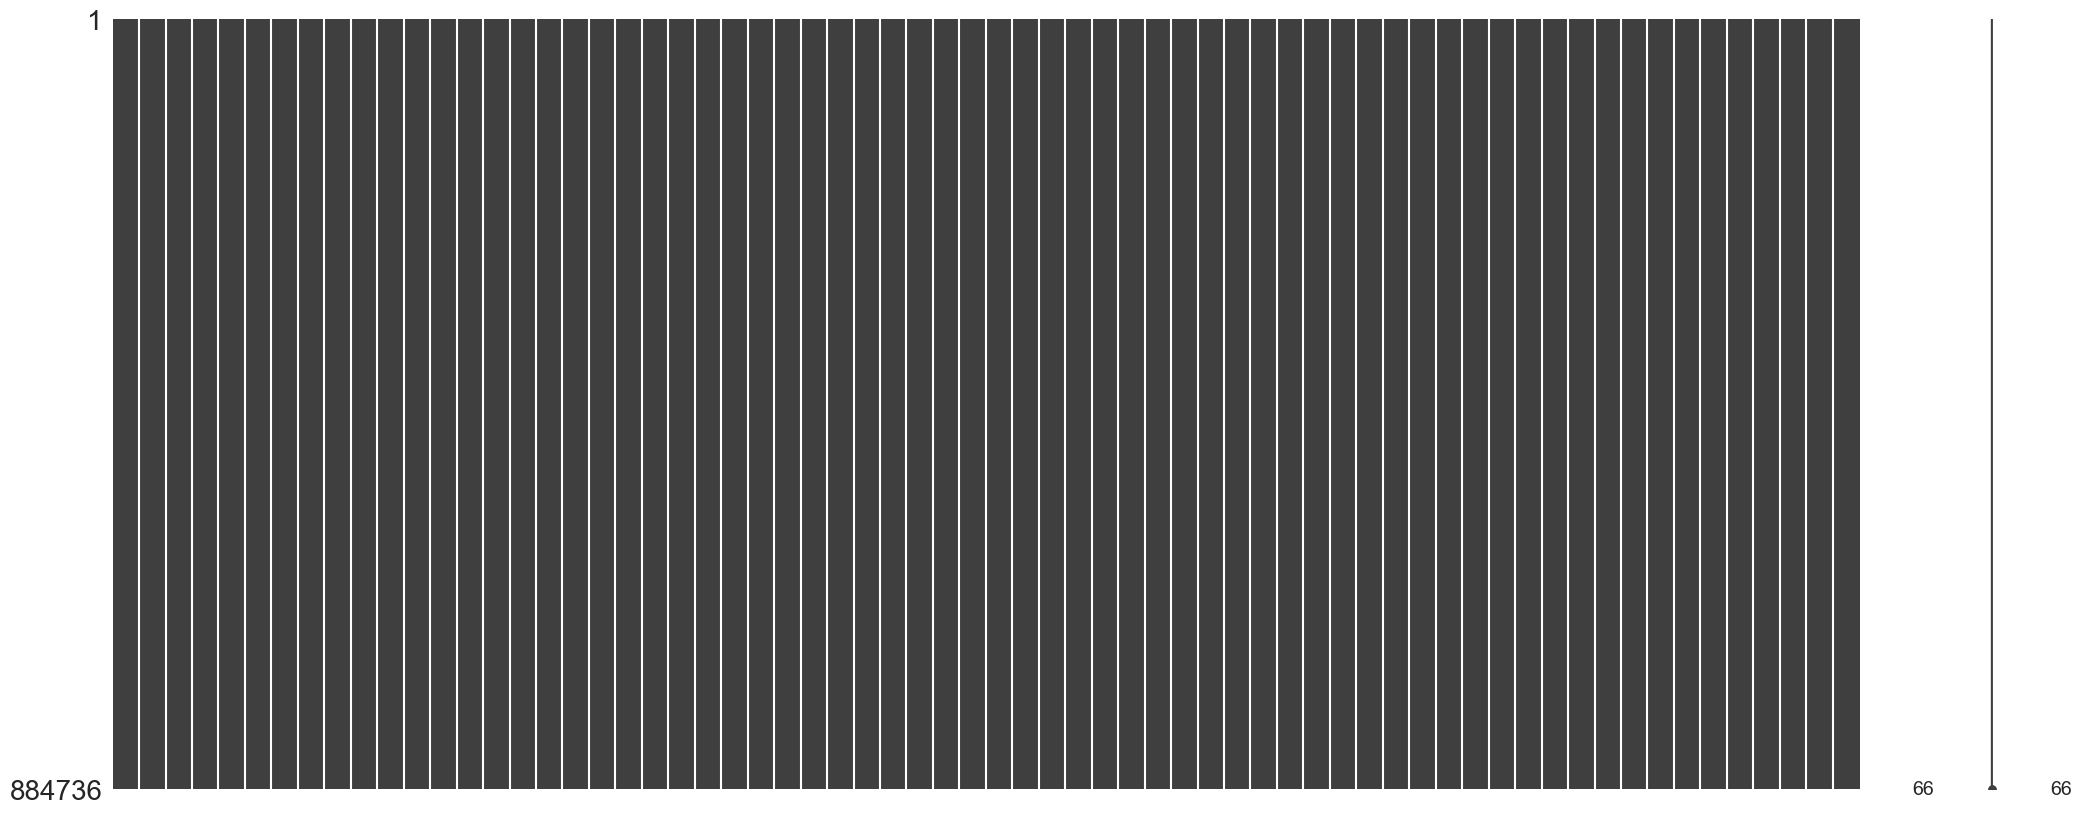

In [7]:
# Plot missing data
msno.matrix(data)

We have no missing data as expected.

<AxesSubplot: xlabel='profit'>

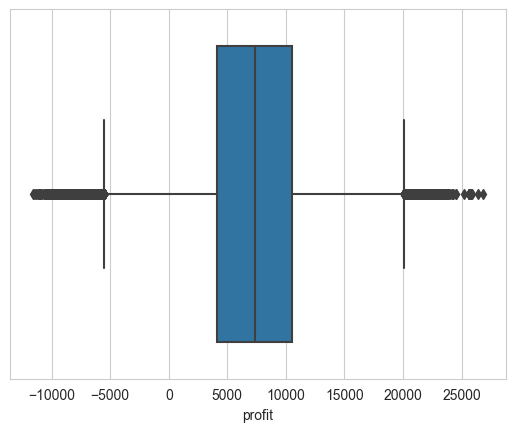

In [8]:
# Analyse the distribution of rewards, for this add the profit column
data["profit"] = data["revenue"] - data["penalty"]
sns.boxplot(x=data["profit"])

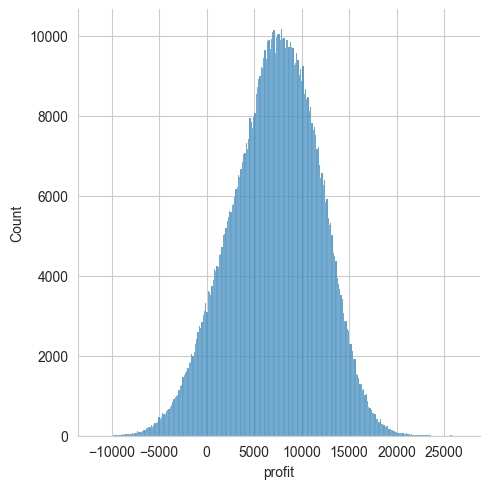

In [9]:
# Analyse the distribution fo samples of rewards
sns.displot(data, x="profit")

We can clearly see a form of a normal distribution of the samples reward.

In [10]:
# Check amount of unique values for the variables
data.nunique().sort_values()

remaining_processing_time_2         1
number_of_jobs_2                    1
number_available_machines_2         1
number_available_machines_4         2
number_available_machines_1         2
                                ...  
slack_time_mean                578432
slack_time_sum                 578480
slack_time_variance            578659
profit                         601096
duration                       662066
Length: 67, dtype: int64

We see already that some variables that have to be removed because they have only one value. In this case this is because we do not have any orders in our set for product type 2 which is not produced anymore in the plant.

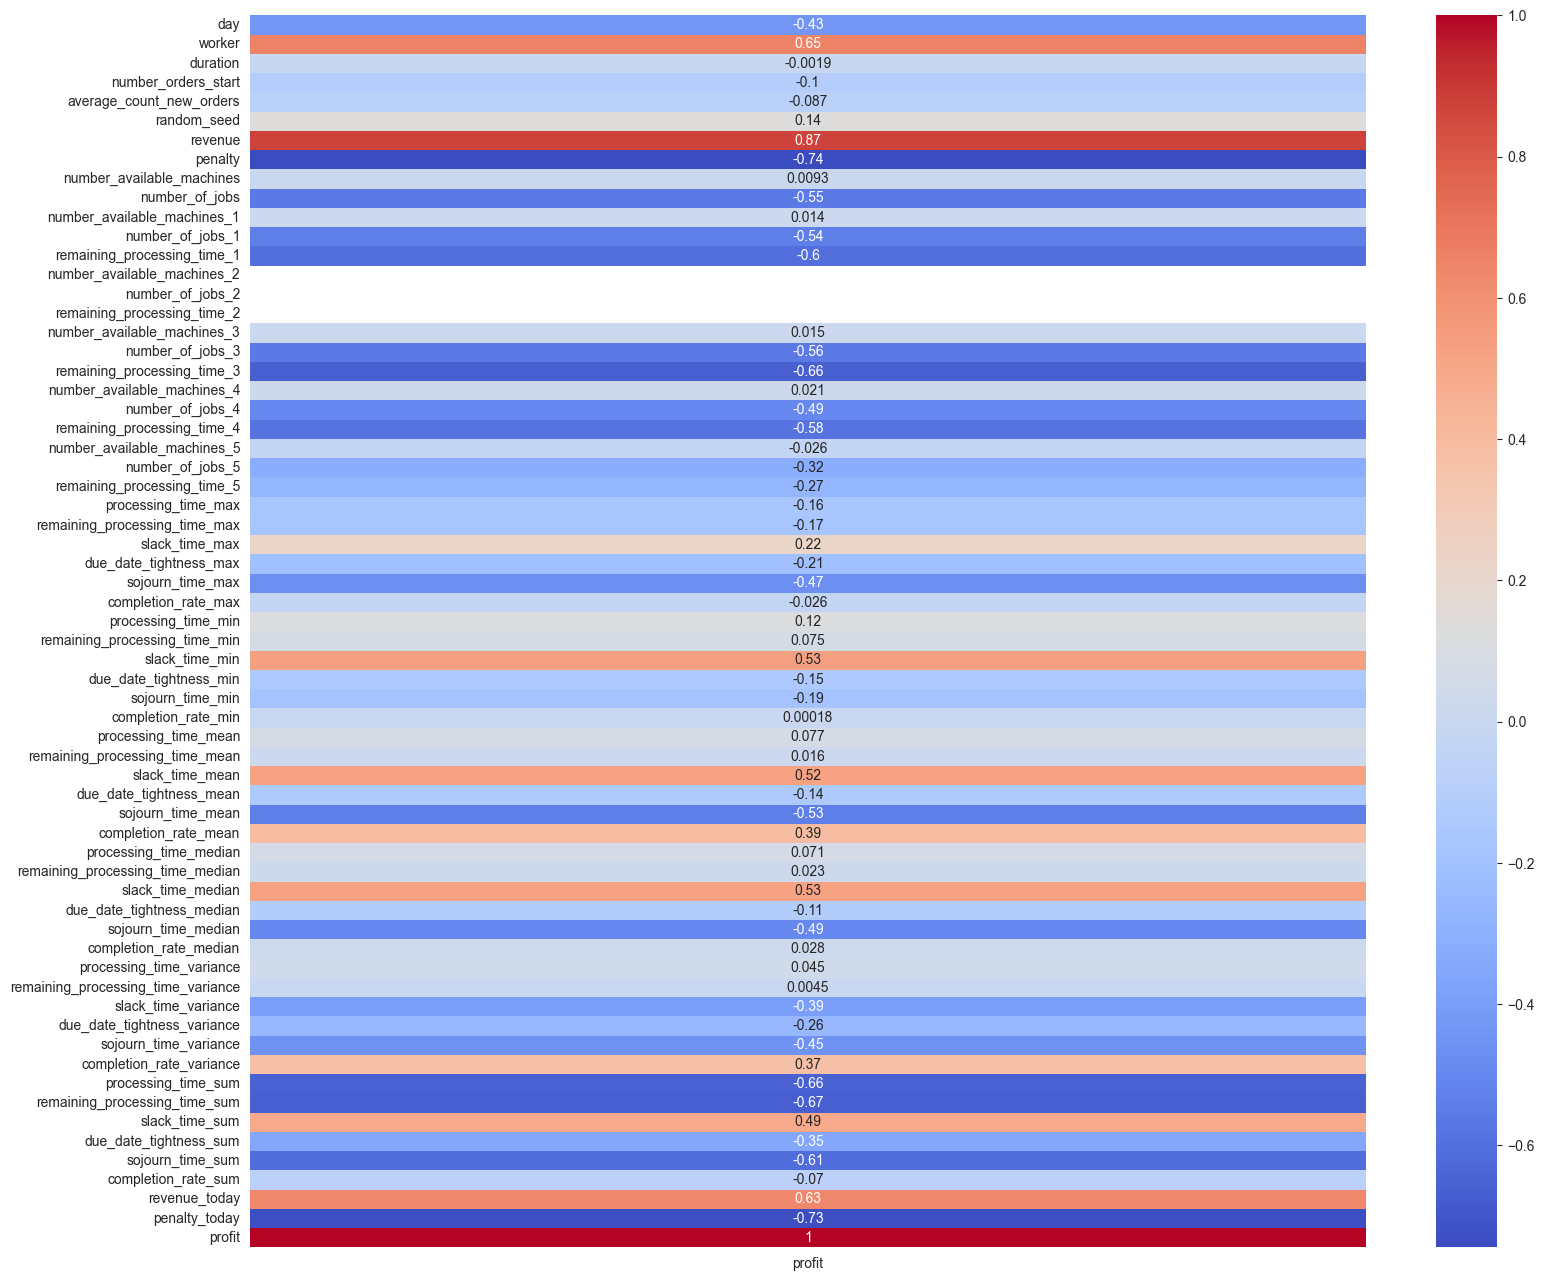

In [11]:
# Analyse the correlation of different variables
plt.figure(figsize=(18,16))
sns.heatmap(data.corr(numeric_only = True)[["profit"]], annot=True, cmap="coolwarm")
plt.show()

When checking the correlation we can that different variables seem to have a major correlation with the target, which increases the chance that we are able to learn meaningful relations.

In the next step we analyse which dispatching rules performed best and additional information regarding the distribution of the best dispatching rules.

In [12]:
# Select subset of best performing rules for each combination of experiment parameters
idx = data.groupby(["random_seed", "priority_rule_start", "day", "worker",
                    "number_orders_start", "average_count_new_orders", "due_date_range"])['profit'].transform(max) == data['profit']
data_best = data[idx]
print("The resulting dataframes shape:", data_best.shape)

The resulting dataframes shape: (257999, 67)


We can directly see that not every time only one dispatching rule performed best, which is why we have to analyse these cases in more detail.

In [13]:
# Analyse number of similar performing dispatching rules per day
data_best.groupby("day").size()

day
3      9420
4      9069
5      8949
8     49152
9      7175
10     6762
11     6630
12     6724
15    49152
16     6899
17     6925
18     6889
19     6859
22    49152
23     7294
24     7087
25     7074
26     6787
dtype: int64

We see that on every Monday in the simulation the performance of all dispatching rules is the same. This can be caused by the weekend transition in the way we simulate the data. Therefore, we remove these data points from our set, as they do not provide any value for the learning problem.

In [14]:
# Remove dates without learning values
data_best = data_best[~data_best.day.isin([8, 15, 22])]
print("The resulting dataframes shape:", data_best.shape)

The resulting dataframes shape: (110543, 67)


What is interesting to know is which dispatching rules often share the first place to analyse if it makes sense to reduce the decision room.

In [15]:
# Show the number of time each priority rule was chosen
data_best.groupby("priority_rule_score").size()

priority_rule_score
assign_priority_cr       7471
assign_priority_ds      15012
assign_priority_edd     21462
assign_priority_fifo    22261
assign_priority_lpt     14791
assign_priority_mdd     16794
assign_priority_spt      6793
assign_priority_srpt     5959
dtype: int64

We can see that all priority rules are chosen in some cases, which is why we cannot remove some rules from the action space.

In [16]:
# Collect data about co-occurrence of best performing rules
groups = data_best.groupby(["random_seed", "priority_rule_start", "day", "worker",
                    "number_orders_start", "average_count_new_orders", "due_date_range"])["priority_rule_score"]
occurrence = []
for symbol, group in groups:
    if len(group) > 1:
        for element_1 in group:
            for element_2 in group:
                if element_1 != element_2:
                    occurrence.append({"First rule": element_1, "Second rule": element_2})
df_vis_co_occurrence = pd.DataFrame(occurrence)
vis_co_occurrence = pd.crosstab(df_vis_co_occurrence['First rule'], df_vis_co_occurrence['Second rule'], normalize=True)

[Text(0, 0.5, 'assign_priority_cr'),
 Text(0, 1.5, 'assign_priority_ds'),
 Text(0, 2.5, 'assign_priority_edd'),
 Text(0, 3.5, 'assign_priority_fifo'),
 Text(0, 4.5, 'assign_priority_lpt'),
 Text(0, 5.5, 'assign_priority_mdd'),
 Text(0, 6.5, 'assign_priority_spt'),
 Text(0, 7.5, 'assign_priority_srpt')]

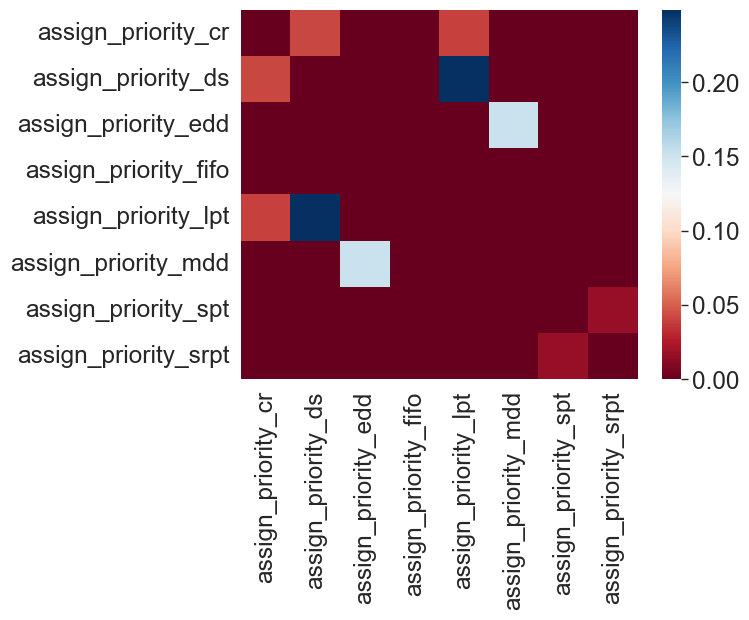

In [17]:
# Plot co-occurrence of dispatching rules
plt.figure()
sns.set_style('white')
sns.set_context('paper', font_scale = 2)
ax = sns.heatmap(vis_co_occurrence, cmap='RdBu')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

Based on the previous visualization we can see a stronger relation between minimal slack and the longest processing time metrics as well as between the earliest due date and the modified due date rule. While we expect similar performance of the earliest due date and modified due date heuristics the relation between the longest processing time and minimal slack time is more surprising, but can be explained by the formula of minimal slack which contains the negative of remaining processing time which explain the similar performance to the longest processing time heuristic.

In [18]:
# Create the difference between best and the other priority rule in each case and remove the zero cases
profit_difference = data.groupby(["random_seed", "priority_rule_start", "day", "worker",
                    "number_orders_start", "average_count_new_orders", "due_date_range"])['profit'].transform(max) - data['profit']
profit_difference = profit_difference[profit_difference != 0]

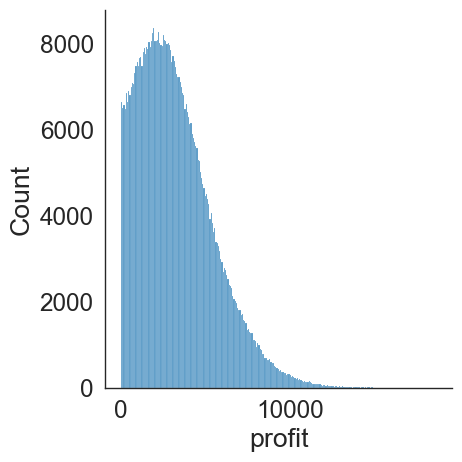

In [19]:
# Analyse the distribution of samples of for the profit difference
sns.displot(x = profit_difference)

We can see that there are differences in the obtained profit of different approaches that are high enough, so that it manifests an interesting learning problem.

# Data processing

## Classification

We now have to decide how to create the final dataset based on two options. We could either use only samples where only rule is chosen or select a rule from the best performing ones and use it as flag. The first option would induce a major data loss and would ignore an important aspect of the learning problem which is why we use the second approach. For this we decided to use a random selection of the best performing dispatching rule to keep the data distribution intact.

In [20]:
# Sample only one dispatching rule as best dispatching rule
data_best_selected = data_best.sample(frac=1, random_state=RANDOM_STATE).drop_duplicates(["random_seed", "priority_rule_start", "day", "worker",
                    "number_orders_start", "average_count_new_orders", "due_date_range"])
print("The resulting dataframes shape:", data_best_selected.shape)

The resulting dataframes shape: (92160, 67)


In [21]:
# Analyse the distribution of best performing rules
data_best_selected.groupby("priority_rule_score").size()

priority_rule_score
assign_priority_cr       6373
assign_priority_ds       9656
assign_priority_edd     18434
assign_priority_fifo    22261
assign_priority_lpt      9638
assign_priority_mdd     13717
assign_priority_spt      6458
assign_priority_srpt     5623
dtype: int64

Based on the removal we can see a changed frequency of different rules as some rules more often co-occurred with other rules as we already analysed in the last section.

In [22]:
# Remove non-unique columns as they offer no value and are semantically not important for the learning problem
data_best_selected.drop(data_best_selected.nunique()[data_best_selected.nunique()==1].index, axis = 1, inplace = True)

In [23]:
# Additionally we remove experiment parameter which are also not available in praxis and should not be included in the learning problem
data_best_selected.drop(['random_seed', 'day', 'duration', 'due_date_range', 'penalty', 'profit', "worker", "number_orders_start", "average_count_new_orders", "revenue"], axis = 1, inplace = True)

In [24]:
# Rename the targets for better readability in the analysis of the models
data_best_selected["priority_rule_score"] = data_best_selected.priority_rule_score.str.replace("assign_priority_", "")

In [25]:
# Change the data types to fit for the modelling
data_best_selected = data_best_selected.astype({"priority_rule_start": "category",
                             "priority_rule_score": "category"})

In [26]:
# Final analysis of the resulting dataframe
data_best_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92160 entries, 530422 to 128591
Data columns (total 54 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   priority_rule_start                 92160 non-null  category
 1   priority_rule_score                 92160 non-null  category
 2   number_available_machines           92160 non-null  int64   
 3   number_of_jobs                      92160 non-null  int64   
 4   number_available_machines_1         92160 non-null  int64   
 5   number_of_jobs_1                    92160 non-null  int64   
 6   remaining_processing_time_1         92160 non-null  float64 
 7   number_available_machines_3         92160 non-null  int64   
 8   number_of_jobs_3                    92160 non-null  int64   
 9   remaining_processing_time_3         92160 non-null  float64 
 10  number_available_machines_4         92160 non-null  int64   
 11  number_of_jobs_4      

In [27]:
# Save the training data
# with open(r"../data/processed/data_processed_classification_training.pickle", "wb") as output_file:
#    pickle.dump(data_best_selected, output_file)

In [28]:
# Repeat the preprocessing for the validation data
# Preprocess data
data_5["profit"] = data_5["revenue"] - data_5["penalty"]
states = pd.DataFrame(data_5.state.tolist())
data_5 = pd.concat([data_5, states], axis = 1)
data_5.drop(["state"], axis = 1, inplace = True)
# Select best performing rules
idx = data_5.groupby(["random_seed", "priority_rule_start", "day", "worker",
                    "number_orders_start", "average_count_new_orders", "due_date_range"])['profit'].transform(max) == data_5['profit']
data_validate_best = data_5[idx]
data_validate_best = data_validate_best[~data_validate_best.day.isin([8, 15, 22])]
data_validate_best_selected = data_validate_best.sample(frac=1, random_state=RANDOM_STATE).drop_duplicates(["random_seed", "priority_rule_start", "day", "worker",
                    "number_orders_start", "average_count_new_orders", "due_date_range"])
# Drop not needed column
data_validate_best_selected.drop(data_validate_best_selected.nunique()[data_validate_best_selected.nunique()==1].index, axis = 1, inplace = True)
data_validate_best_selected.drop(['random_seed', 'day', 'duration', 'due_date_range', 'penalty', 'profit', "worker", "number_orders_start", "average_count_new_orders", "revenue"], axis = 1, inplace = True)
# Prepare data types
data_validate_best_selected["priority_rule_score"] = data_validate_best_selected.priority_rule_score.str.replace("assign_priority_", "")
data_validate_best_selected = data_validate_best_selected.astype({"priority_rule_start": "category",
                             "priority_rule_score": "category"})
print("The resulting dataframes shape:", data_validate_best_selected.shape)

The resulting dataframes shape: (23040, 54)


In [29]:
# Save the validation data
# with open(r"../data/processed/data_processed_classification_validation.pickle", "wb") as output_file:
#    pickle.dump(data_validate_best_selected, output_file)

## Regression

For the regression case we can leave all data samples as they all offer values information about the target variable profit which can be used to learn more for the regression model.

In [30]:
# Execute the preprocessing for the training data
# Drop not needed columns
data_regression_training = data.drop(data.nunique()[data.nunique()==1].index, axis = 1)
data_regression_training.drop(['random_seed', 'day', 'duration', 'due_date_range', 'penalty', "worker", "number_orders_start", "average_count_new_orders", "revenue"], axis = 1, inplace = True)
# Change data types
data_regression_training["priority_rule_score"] = data_regression_training.priority_rule_score.str.replace("assign_priority_", "")
data_regression_training = data_regression_training.astype({"priority_rule_start": "category",
                             "priority_rule_score": "category"})

In [31]:
# Save the validation data
# with open(r"../data/processed/data_processed_regression_training.pickle", "wb") as output_file:
#   pickle.dump(data_regression_training, output_file)

In [32]:
# Execute the preprocessing for the validation data
# Drop not needed columns
data_regression_validation = data_5.drop(data_5.nunique()[data_5.nunique()==1].index, axis = 1)
data_regression_validation.drop(['random_seed', 'day', 'duration', 'due_date_range', 'penalty', "worker", "number_orders_start", "average_count_new_orders", "revenue"], axis = 1, inplace = True)
# Change data types
data_regression_validation["priority_rule_score"] = data_regression_validation.priority_rule_score.str.replace("assign_priority_", "")
data_regression_validation = data_regression_validation.astype({"priority_rule_start": "category",
                             "priority_rule_score": "category"})

In [33]:
# Save the validation data
# with open(r"../data/processed/data_processed_regression_validation.pickle", "wb") as output_file:
#    pickle.dump(data_regression_validation, output_file)